In [1]:
%%html
<style>
.output_subarea.output_text.output_stream.output_stdout > pre {
   width:max-content;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output > pre {
   width:max-content;
}
</style>

# Menu

# Librerias

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import sys
import plotly.graph_objs as go
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense

# Parametros

In [4]:
graficas_path = "graficas/"

# Spark init

In [5]:
# from pyspark.sql import SparkSession
# from pyspark import SparkConf
# spark = SparkSession.builder.appName('ingesta_tweets').getOrCreate()

In [6]:
# from pyspark.sql import functions as F

# Primera prueba con LSTM

In [7]:
prices_dataframe = pd.read_csv("data/all_both_cryptocurrency.csv", parse_dates=["date"])
prices_dataframe["date"] = prices_dataframe.date.dt.date
prices_dataframe.sort_values(by=["date", "hour"], ascending=True, inplace=True)

In [8]:
full_raw_data = prices_dataframe.values

In [9]:
partition = 0.8
end_partition = int(np.floor(prices_dataframe.shape[0]*partition))

In [166]:
end_partition

14602

In [10]:
train_raw_data, test_raw_data = full_raw_data[:end_partition], full_raw_data[end_partition:]

# Simple LSTM

In [11]:
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()

In [12]:
prices_dataframe.columns

Index(['date', 'hour', 'close_btc', 'high_btc', 'low_btc', 'volume_btc',
       'volume_btc_usd', 'close_eth', 'high_eth', 'low_eth', 'volume_eth',
       'volume_eth_usd'],
      dtype='object')

In [13]:
train_close_data = train_raw_data[:,2].reshape(train_raw_data.shape[0],1)
test_close_data = test_raw_data[:,2].reshape(test_raw_data.shape[0],1)
full_close_data = full_raw_data[:,2].reshape(full_raw_data.shape[0],1)

In [14]:
datetime_fun = lambda d_h: dt.datetime(d_h[0].year, d_h[0].month, d_h[0].day, d_h[1])
time_series = prices_dataframe[["date","hour"]].apply(datetime_fun, axis=1)

In [15]:
model_sc1 = scl.fit(train_close_data)

In [16]:
full_close_data_scaled = model_sc1.transform(full_close_data)

In [17]:
# fig = plotly.subplots.make_subplots(rows=1, cols=2)
# fig.add_trace(
#     plotly.graph_objs.Line( name="Original", x=time_series, y=full_close_data[:,0]),
#     row=1,col=1
# )
# fig.add_trace(
#     plotly.graph_objs.Line( name="Transformado", x=time_series, y=full_close_data_scaled[:,0]),
#     row=1,col=2
# )
# # Add figure title
# fig.update_layout(
#     title_text="Original y transformación en scala min-max de la variable Close"
# )

# # Set x-axis title
# fig.update_xaxes(title_text="Fecha")

# # Set y-axes titles
# fig.update_yaxes(title_text="<b>Original</b> Close", row=1,col=1)
# fig.update_yaxes(title_text="<b>Transformación</b> Close", row=1,col=2)

# plotly.offline.plot(fig, filename="graficas/min_max_transformation.html")

In [89]:
batches_length = 32
hours_history_length = 48
epochs = 30
num_hours_after = 5

In [18]:
all_data_transformed = [[full_close_data_scaled[ind - hours_history_length:ind].reshape(hours_history_length).tolist(),( float(full_close_data[ind][0]/full_close_data[ind-1][0])-1)] for ind in range(hours_history_length,full_close_data.shape[0])]

In [102]:
#full_zipped = np.array([[full_close_data_scaled[ind],(full_close_data[ind+num_hours_after]/full_close_data[ind]) - 1] for ind in range(len(full_close_data)-num_hours_after)])
full_zipped = np.array([[full_close_data_scaled[ind],(full_close_data_scaled[ind+1])] for ind in range(len(full_close_data)-1)])

In [103]:
data_full = np.array([
            full_zipped[ind-hours_history_length:ind]
            for ind in range(hours_history_length,len(full_zipped))
                  ])
x_full = data_full[:,:,0]
y_full = data_full[:,:,1]

In [104]:
X_train = (x_full[:train_close_data.shape[0] - hours_history_length]).astype("float")
Y_train = (y_full[:train_close_data.shape[0] - hours_history_length]).astype("float")[:,-1,:]
X_test = (x_full[train_close_data.shape[0] - hours_history_length:]).astype("float")
Y_test = (y_full[train_close_data.shape[0] - hours_history_length:]).astype("float")[:,-1,:]
Y_train = Y_train.reshape(Y_train.shape[0],1)
Y_test = Y_test.reshape(Y_test.shape[0],1)

# Alternativa basica

In [105]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation
import time

In [106]:
model = Sequential()

model.add(LSTM(126,input_shape=(hours_history_length,1)
            ,
        return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(
        256,
        return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))
model.add(Activation('linear'))

start = time.time()
model.compile (loss = 'mse', optimizer = 'rmsprop')

print ('compilation time: '), time.time() - start

compilation time: 


(None, 0.010061264038085938)

In [107]:
from scipy import stats
import numpy as np

In [108]:
no_rare_inx = (np.where(stats.zscore(Y_train) <= 3))[0]

In [109]:
history = model.fit(X_train[no_rare_inx],Y_train[no_rare_inx], validation_data=(X_test, Y_test), batch_size=256, epochs=100)

Train on 14308 samples, validate on 3650 samples
Epoch 1/100
14308/14308 [==============================] - 21s 1ms/sample - loss: 0.0072 - val_loss: 0.0012
Epoch 2/100
14308/14308 [==============================] - 18s 1ms/sample - loss: 0.0025 - val_loss: 6.1464e-04
Epoch 3/100
14308/14308 [==============================] - 18s 1ms/sample - loss: 0.0019 - val_loss: 5.0114e-04
Epoch 4/100
14308/14308 [==============================] - 18s 1ms/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 5/100
14308/14308 [==============================] - 18s 1ms/sample - loss: 0.0012 - val_loss: 0.0026
Epoch 6/100
14308/14308 [==============================] - 21s 1ms/sample - loss: 0.0012 - val_loss: 0.0026
Epoch 7/100
14308/14308 [==============================] - 20s 1ms/sample - loss: 9.9730e-04 - val_loss: 0.0024
Epoch 8/100
14308/14308 [==============================] - 18s 1ms/sample - loss: 9.8306e-04 - val_loss: 7.9774e-04
Epoch 9/100
14308/14308 [==============================] - 18s 1ms/

14308/14308 [==============================] - 19s 1ms/sample - loss: 1.8228e-04 - val_loss: 1.9346e-04
Epoch 72/100
14308/14308 [==============================] - 19s 1ms/sample - loss: 1.7806e-04 - val_loss: 9.7544e-05
Epoch 73/100
14308/14308 [==============================] - 19s 1ms/sample - loss: 1.7421e-04 - val_loss: 9.3425e-05
Epoch 74/100
14308/14308 [==============================] - 20s 1ms/sample - loss: 1.8449e-04 - val_loss: 9.4988e-05
Epoch 75/100
14308/14308 [==============================] - 20s 1ms/sample - loss: 1.8104e-04 - val_loss: 5.0570e-05
Epoch 76/100
14308/14308 [==============================] - 19s 1ms/sample - loss: 1.6987e-04 - val_loss: 2.4238e-04
Epoch 77/100
14308/14308 [==============================] - 19s 1ms/sample - loss: 1.7476e-04 - val_loss: 1.7251e-04
Epoch 78/100
14308/14308 [==============================] - 19s 1ms/sample - loss: 1.7642e-04 - val_loss: 1.1067e-04
Epoch 79/100
14308/14308 [==============================] - 19s 1ms/sample - 

In [110]:
y_predict = model.predict(X_test)

In [142]:
y_predict_train = model.predict(X_train)

In [165]:
fig = plotly.subplots.make_subplots(rows=1, cols=1)
fig.add_trace(
    plotly.graph_objs.Line( name="Original", y=hola['y_real'], x=list(range(y_predict_train.shape[0]))),
    row=1,col=1
)
fig.add_trace(
    plotly.graph_objs.Line( name="Transformado", y=hola['y_predict'], x=list(range(y_predict_train.shape[0]))),
    row=1,col=1
)
fig.add_trace(go.Scatter(x=np.where(hola["diff"]<=0)[0], y=hola["y_real"][np.where(hola["diff"]<=0)[0]],
                    mode='markers', name='negative'))

fig.add_trace(go.Scatter(x=np.where(hola["diff"]>0)[0], y=hola["y_real"][np.where(hola["diff"]>0)[0]],
                    mode='markers', name='positive'))

# Add figure title
fig.update_layout(
    title_text="Original y transformación en scala min-max de la variable Close"
)

# Set x-axis title
fig.update_xaxes(title_text="Fecha")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Original</b> Close", row=1,col=1)
fig.update_yaxes(title_text="<b>Transformación</b> Close", row=1,col=2)

plotly.offline.plot(fig, filename="graficas/lstm_normal.html")

'graficas/lstm_normal.html'

array([    5,     6,     7, ..., 14548, 14552, 14553])

In [143]:
import pandas as pd
hola = pd.DataFrame(X_train.reshape(*X_train.shape[:2]))
hola['y_real'] = Y_train[:,0]
hola['y_predict'] = y_predict_train[:,0]

In [153]:
hola["diff"] = np.where((hola['y_predict'].shift(-1) - hola['y_predict']) > 0, 1,-1)

In [152]:
hola.head()

0         1         2         3         4         5         6  \
0  0.038344  0.037558  0.035422  0.035765  0.036248  0.036013  0.035103   
1  0.037558  0.035422  0.035765  0.036248  0.036013  0.035103  0.033686   
2  0.035422  0.035765  0.036248  0.036013  0.035103  0.033686  0.034450   
3  0.035765  0.036248  0.036013  0.035103  0.033686  0.034450  0.032416   
4  0.036248  0.036013  0.035103  0.033686  0.034450  0.032416  0.032967   

          7         8         9  ...        41        42        43        44  \
0  0.033686  0.034450  0.032416  ...  0.038211  0.038052  0.038204  0.037168   
1  0.034450  0.032416  0.032967  ...  0.038052  0.038204  0.037168  0.037169   
2  0.032416  0.032967  0.033339  ...  0.038204  0.037168  0.037169  0.037402   
3  0.032967  0.033339  0.033197  ...  0.037168  0.037169  0.037402  0.037425   
4  0.033339  0.033197  0.031466  ...  0.037169  0.037402  0.037425  0.038461   

         45        46        47    y_real  y_predict  diff  
0  0.037169  0.037402  0.037425  0.038461   0.042064    -1  
1  0.037402  0.037425  0.038461  0.039480   0.043014    -1  
2  0.037425  0.038461  0.039480  0.042139   0.044260    -1  
3  0.038461  0.039480  0.042139  0.041275   0.046950    -1  
4  0.039480  0.042139  0.041275  0.042235   0.046965    -1  

[5 rows x 51 columns]

In [139]:
np.average(hola["diff"]**2)

0.00015800291498135812

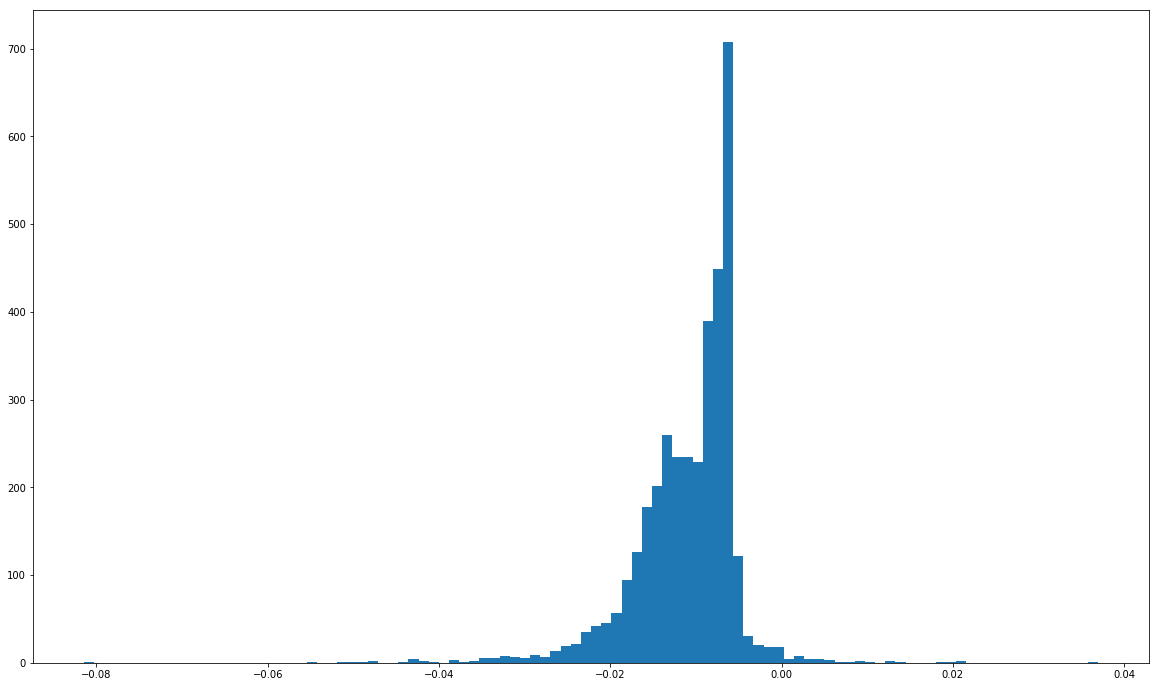

In [137]:
plt.figure(figsize=(20,12))
plt.hist(hola["diff"], 100)
plt.show()

In [132]:
hola

0         1         2         3         4         5         6  \
0     0.108409  0.109843  0.111209  0.111558  0.112002  0.111465  0.111363   
1     0.109843  0.111209  0.111558  0.112002  0.111465  0.111363  0.111621   
2     0.111209  0.111558  0.112002  0.111465  0.111363  0.111621  0.111865   
3     0.111558  0.112002  0.111465  0.111363  0.111621  0.111865  0.111476   
4     0.112002  0.111465  0.111363  0.111621  0.111865  0.111476  0.111496   
5     0.111465  0.111363  0.111621  0.111865  0.111476  0.111496  0.112649   
6     0.111363  0.111621  0.111865  0.111476  0.111496  0.112649  0.112675   
7     0.111621  0.111865  0.111476  0.111496  0.112649  0.112675  0.112153   
8     0.111865  0.111476  0.111496  0.112649  0.112675  0.112153  0.112446   
9     0.111476  0.111496  0.112649  0.112675  0.112153  0.112446  0.112341   
10    0.111496  0.112649  0.112675  0.112153  0.112446  0.112341  0.112184   
11    0.112649  0.112675  0.112153  0.112446  0.112341  0.112184  0.112448   
12    0.112675  0.112153  0.112446  0.112341  0.112184  0.112448  0.113624   
13    0.112153  0.112446  0.112341  0.112184  0.112448  0.113624  0.112483   
14    0.112446  0.112341  0.112184  0.112448  0.113624  0.112483  0.111133   
15    0.112341  0.112184  0.112448  0.113624  0.112483  0.111133  0.112073   
16    0.112184  0.112448  0.113624  0.112483  0.111133  0.112073  0.111688   
17    0.112448  0.113624  0.112483  0.111133  0.112073  0.111688  0.111412   
18    0.113624  0.112483  0.111133  0.112073  0.111688  0.111412  0.111312   
19    0.112483  0.111133  0.112073  0.111688  0.111412  0.111312  0.110984   
20    0.111133  0.112073  0.111688  0.111412  0.111312  0.110984  0.110829   
21    0.112073  0.111688  0.111412  0.111312  0.110984  0.110829  0.110992   
22    0.111688  0.111412  0.111312  0.110984  0.110829  0.110992  0.111471   
23    0.111412  0.111312  0.110984  0.110829  0.110992  0.111471  0.111296   
24    0.111312  0.110984  0.110829  0.110992  0.111471  0.111296  0.111491   
25    0.110984  0.110829  0.110992  0.111471  0.111296  0.111491  0.111276   
26    0.110829  0.110992  0.111471  0.111296  0.111491  0.111276  0.111277   
27    0.110992  0.111471  0.111296  0.111491  0.111276  0.111277  0.111318   
28    0.111471  0.111296  0.111491  0.111276  0.111277  0.111318  0.111780   
29    0.111296  0.111491  0.111276  0.111277  0.111318  0.111780  0.111791   
...        ...       ...       ...       ...       ...       ...       ...   
3620  0.432893  0.433124  0.433342  0.431780  0.428016  0.431895  0.433108   
3621  0.433124  0.433342  0.431780  0.428016  0.431895  0.433108  0.432639   
3622  0.433342  0.431780  0.428016  0.431895  0.433108  0.432639  0.439967   
3623  0.431780  0.428016  0.431895  0.433108  0.432639  0.439967  0.438705   
3624  0.428016  0.431895  0.433108  0.432639  0.439967  0.438705  0.438306   
3625  0.431895  0.433108  0.432639  0.439967  0.438705  0.438306  0.439611   
3626  0.433108  0.432639  0.439967  0.438705  0.438306  0.439611  0.436763   
3627  0.432639  0.439967  0.438705  0.438306  0.439611  0.436763  0.436299   
3628  0.439967  0.438705  0.438306  0.439611  0.436763  0.436299  0.436734   
3629  0.438705  0.438306  0.439611  0.436763  0.436299  0.436734  0.434410   
3630  0.438306  0.439611  0.436763  0.436299  0.436734  0.434410  0.429390   
3631  0.439611  0.436763  0.436299  0.436734  0.434410  0.429390  0.430212   
3632  0.436763  0.436299  0.436734  0.434410  0.429390  0.430212  0.428646   
3633  0.436299  0.436734  0.434410  0.429390  0.430212  0.428646  0.431884   
3634  0.436734  0.434410  0.429390  0.430212  0.428646  0.431884  0.432580   
3635  0.434410  0.429390  0.430212  0.428646  0.431884  0.432580  0.431881   
3636  0.429390  0.430212  0.428646  0.431884  0.432580  0.431881  0.431849   
3637  0.430212  0.428646  0.431884  0.432580  0.431881  0.431849  0.433452   
3638  0.428646  0.431884  0.432580  0.431881  0.431849  0.433452  0.429752   
3639  0.431884  0.432580  0.431881 

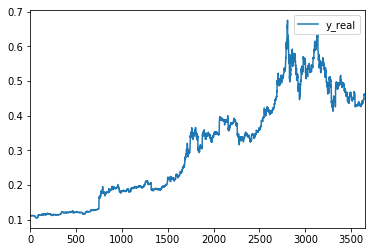

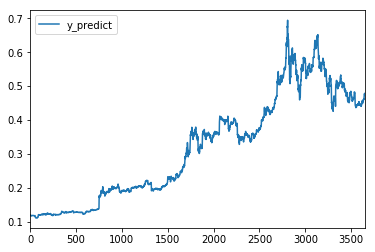

In [115]:
hola.plot.line(y="y_real")
hola.plot.line(y="y_predict")
plt.show()

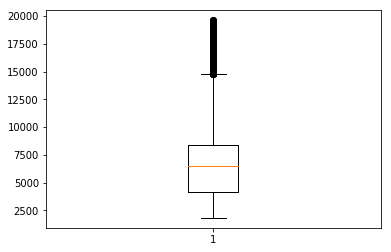

In [100]:
plt.boxplot(full_close_data)
plt.show()

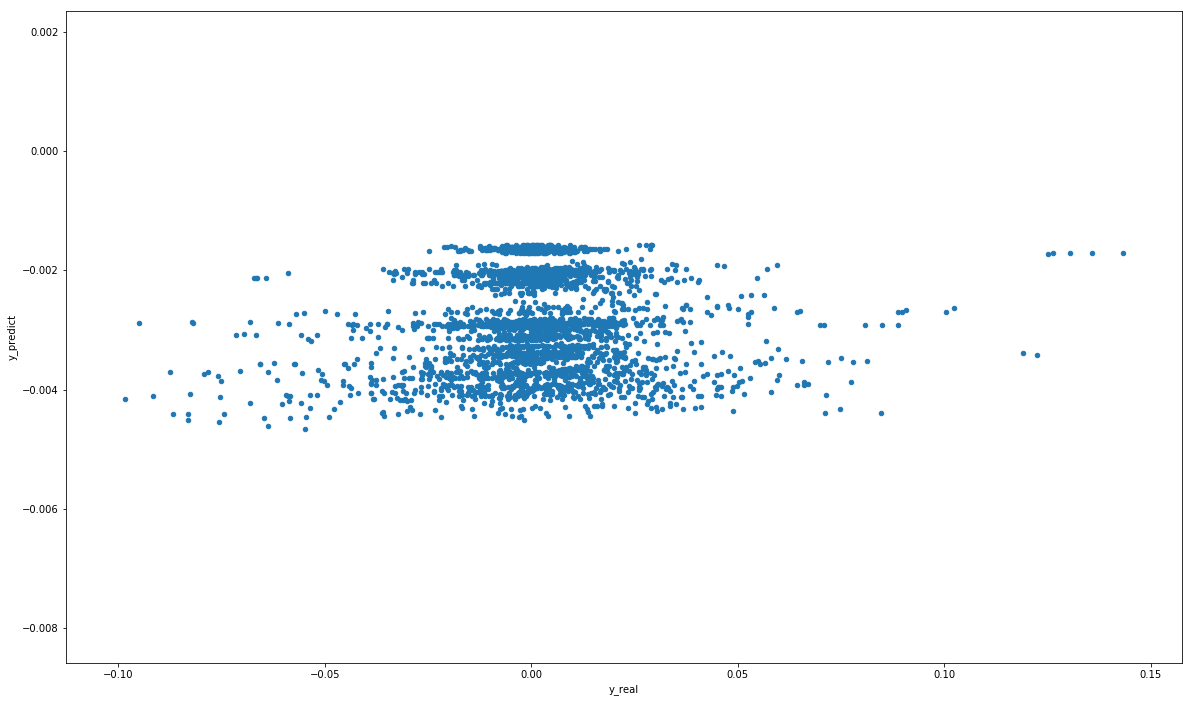

In [101]:
from matplotlib import pyplot as plt
hola.plot.scatter(x="y_real", y="y_predict", figsize=(20,12))
plt.show()

# statefuless

In [25]:
from tensorflow.python.keras import models, layers
import tensorflow as tf
def define_model(len_ts,
                 hidden_neurons = 10,
                 nfeature=1,
                 batch_size=None,
                 stateful=False):
    in_out_neurons = 1
    
    inp = layers.Input(batch_shape= (batch_size, len_ts, nfeature),
                       )  

    rnn = layers.LSTM( 64, 
                      dropout=0.1,
                    return_sequences=True,
                    stateful=stateful,
                    )(inp)
    
    rnn = layers.LSTM( 128, 
                      dropout=0.1,
                    return_sequences=True,
                    stateful=stateful,
                    )(rnn)
    
    dens = layers.Dense(300, activation=tf.nn.relu)(rnn)
    dens = layers.Dense(in_out_neurons)(dens)
    model = models.Model(inputs=[inp],outputs=[dens])
    
    model.compile(loss="mean_squared_error",
                  optimizer="rmsprop", metrics=['mse'])

    return(model,(inp,rnn,dens))

In [26]:
hunits = 256
model_stateless, _ = define_model(
                    hidden_neurons = hunits,
                    len_ts = X_train.shape[1])
model_stateless.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 24, 1)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 24, 64)            16896     
_________________________________________________________________
lstm_3 (LSTM)                (None, 24, 128)           98816     
_________________________________________________________________
dense (Dense)                (None, 24, 300)           38700     
_________________________________________________________________
dense_1 (Dense)              (None, 24, 1)             301       
Total params: 154,713
Trainable params: 154,713
Non-trainable params: 0
_________________________________________________________________


In [27]:
import time
start = time.time()
history = model_stateless.fit(X_train,Y_train,
                             batch_size=1,
                             epochs=300,
                             verbose=2,
                             validation_data=(X_test,Y_test))
end = time.time()
print("Time Took :{:3.2f} min".format( (end-start)/60 ))

Train on 14578 samples, validate on 3650 samples
Epoch 1/300
 - 720s - loss: 1.0728e-04 - mean_squared_error: 1.0728e-04 - val_loss: 7.6469e-05 - val_mean_squared_error: 7.6469e-05
Epoch 2/300
 - 725s - loss: 1.0594e-04 - mean_squared_error: 1.0594e-04 - val_loss: 7.6545e-05 - val_mean_squared_error: 7.6545e-05
Epoch 3/300
 - 731s - loss: 1.0590e-04 - mean_squared_error: 1.0590e-04 - val_loss: 7.6650e-05 - val_mean_squared_error: 7.6650e-05
Epoch 4/300
 - 729s - loss: 1.0592e-04 - mean_squared_error: 1.0592e-04 - val_loss: 7.8283e-05 - val_mean_squared_error: 7.8283e-05
Epoch 5/300
 - 730s - loss: 1.0593e-04 - mean_squared_error: 1.0593e-04 - val_loss: 8.0131e-05 - val_mean_squared_error: 8.0131e-05
Epoch 6/300
 - 730s - loss: 1.0592e-04 - mean_squared_error: 1.0592e-04 - val_loss: 7.6644e-05 - val_mean_squared_error: 7.6644e-05
Epoch 7/300
 - 729s - loss: 1.0591e-04 - mean_squared_error: 1.0591e-04 - val_loss: 8.4196e-05 - val_mean_squared_error: 8.4196e-05
Epoch 8/300
 - 729s - loss:

Epoch 63/300
 - 726s - loss: 1.0592e-04 - mean_squared_error: 1.0592e-04 - val_loss: 7.8503e-05 - val_mean_squared_error: 7.8503e-05
Epoch 64/300
 - 726s - loss: 1.0591e-04 - mean_squared_error: 1.0591e-04 - val_loss: 7.6474e-05 - val_mean_squared_error: 7.6474e-05
Epoch 65/300
 - 726s - loss: 1.0591e-04 - mean_squared_error: 1.0591e-04 - val_loss: 7.6470e-05 - val_mean_squared_error: 7.6470e-05
Epoch 66/300
 - 726s - loss: 1.0591e-04 - mean_squared_error: 1.0591e-04 - val_loss: 7.6835e-05 - val_mean_squared_error: 7.6835e-05
Epoch 67/300
 - 726s - loss: 1.0589e-04 - mean_squared_error: 1.0589e-04 - val_loss: 7.6711e-05 - val_mean_squared_error: 7.6711e-05
Epoch 68/300
 - 726s - loss: 1.0593e-04 - mean_squared_error: 1.0593e-04 - val_loss: 7.7043e-05 - val_mean_squared_error: 7.7043e-05
Epoch 69/300
 - 726s - loss: 1.0593e-04 - mean_squared_error: 1.0593e-04 - val_loss: 7.6464e-05 - val_mean_squared_error: 7.6464e-05
Epoch 70/300
 - 726s - loss: 1.0589e-04 - mean_squared_error: 1.0589e

Epoch 125/300
 - 726s - loss: 1.0590e-04 - mean_squared_error: 1.0590e-04 - val_loss: 7.6571e-05 - val_mean_squared_error: 7.6571e-05
Epoch 126/300
 - 726s - loss: 1.0590e-04 - mean_squared_error: 1.0590e-04 - val_loss: 7.7484e-05 - val_mean_squared_error: 7.7484e-05
Epoch 127/300
 - 726s - loss: 1.0592e-04 - mean_squared_error: 1.0592e-04 - val_loss: 7.6479e-05 - val_mean_squared_error: 7.6479e-05
Epoch 128/300
 - 726s - loss: 1.0592e-04 - mean_squared_error: 1.0592e-04 - val_loss: 7.7643e-05 - val_mean_squared_error: 7.7643e-05
Epoch 129/300
 - 726s - loss: 1.0592e-04 - mean_squared_error: 1.0592e-04 - val_loss: 7.8716e-05 - val_mean_squared_error: 7.8716e-05
Epoch 130/300
 - 726s - loss: 1.0593e-04 - mean_squared_error: 1.0593e-04 - val_loss: 7.6465e-05 - val_mean_squared_error: 7.6465e-05
Epoch 131/300
 - 726s - loss: 1.0590e-04 - mean_squared_error: 1.0590e-04 - val_loss: 7.8377e-05 - val_mean_squared_error: 7.8377e-05
Epoch 132/300
 - 726s - loss: 1.0592e-04 - mean_squared_error:

Epoch 187/300
 - 733s - loss: 1.0590e-04 - mean_squared_error: 1.0590e-04 - val_loss: 7.9195e-05 - val_mean_squared_error: 7.9195e-05
Epoch 188/300
 - 733s - loss: 1.0594e-04 - mean_squared_error: 1.0594e-04 - val_loss: 7.6897e-05 - val_mean_squared_error: 7.6897e-05
Epoch 189/300
 - 733s - loss: 1.0592e-04 - mean_squared_error: 1.0592e-04 - val_loss: 7.8314e-05 - val_mean_squared_error: 7.8314e-05
Epoch 190/300
 - 733s - loss: 1.0594e-04 - mean_squared_error: 1.0594e-04 - val_loss: 7.6612e-05 - val_mean_squared_error: 7.6612e-05
Epoch 191/300
 - 733s - loss: 1.0591e-04 - mean_squared_error: 1.0591e-04 - val_loss: 7.6622e-05 - val_mean_squared_error: 7.6622e-05
Epoch 192/300
 - 733s - loss: 1.0593e-04 - mean_squared_error: 1.0593e-04 - val_loss: 7.6774e-05 - val_mean_squared_error: 7.6774e-05
Epoch 193/300
 - 733s - loss: 1.0592e-04 - mean_squared_error: 1.0592e-04 - val_loss: 7.6734e-05 - val_mean_squared_error: 7.6734e-05
Epoch 194/300
 - 734s - loss: 1.0592e-04 - mean_squared_error:

Epoch 249/300
 - 726s - loss: 1.0590e-04 - mean_squared_error: 1.0590e-04 - val_loss: 7.7191e-05 - val_mean_squared_error: 7.7191e-05
Epoch 250/300
 - 726s - loss: 1.0595e-04 - mean_squared_error: 1.0595e-04 - val_loss: 7.6894e-05 - val_mean_squared_error: 7.6894e-05
Epoch 251/300
 - 726s - loss: 1.0590e-04 - mean_squared_error: 1.0590e-04 - val_loss: 7.9539e-05 - val_mean_squared_error: 7.9539e-05
Epoch 252/300
 - 726s - loss: 1.0592e-04 - mean_squared_error: 1.0592e-04 - val_loss: 7.6630e-05 - val_mean_squared_error: 7.6630e-05
Epoch 253/300
 - 726s - loss: 1.0591e-04 - mean_squared_error: 1.0591e-04 - val_loss: 7.6566e-05 - val_mean_squared_error: 7.6566e-05
Epoch 254/300
 - 727s - loss: 1.0590e-04 - mean_squared_error: 1.0590e-04 - val_loss: 8.1191e-05 - val_mean_squared_error: 8.1191e-05
Epoch 255/300
 - 726s - loss: 1.0594e-04 - mean_squared_error: 1.0594e-04 - val_loss: 7.7513e-05 - val_mean_squared_error: 7.7513e-05
Epoch 256/300
 - 726s - loss: 1.0591e-04 - mean_squared_error:

In [28]:
model_stateless.test_on_batch(X_test[0], y=Y_test)

ValueError: Error when checking input: expected input_2 to have 3 dimensions, but got array with shape (24, 1)

In [38]:
y_pred = model_stateless.predict_on_batch(X_test)

In [32]:
np.array([X_test[0]])

array([[[0.11131175],
        [0.11098369],
        [0.11082891],
        [0.11099229],
        [0.11147138],
        [0.11129584],
        [0.11149066],
        [0.11127601],
        [0.11127657],
        [0.1113183 ],
        [0.11177999],
        [0.11179103],
        [0.11201898],
        [0.11200663],
        [0.1118206 ],
        [0.11181873],
        [0.11222241],
        [0.11237942],
        [0.112109  ],
        [0.11283662],
        [0.11318808],
        [0.11314541],
        [0.11291222],
        [0.11287405]]])

In [34]:
y_pred

array([[[0.00032334],
        [0.00032334],
        [0.00032334],
        [0.00032334],
        [0.00032334],
        [0.00032334],
        [0.00032334],
        [0.00032334],
        [0.00032334],
        [0.00032334],
        [0.00032334],
        [0.00032334],
        [0.00032334],
        [0.00032334],
        [0.00032334],
        [0.00032334],
        [0.00032334],
        [0.00032334],
        [0.00032334],
        [0.00032334],
        [0.00032334],
        [0.00032334],
        [0.00032334],
        [0.00032334]]], dtype=float32)

In [40]:
fig = plotly.subplots.make_subplots(rows=1, cols=1)
fig.add_trace(
    plotly.graph_objs.Line( name="Original", x=list(range(len(Y_test[:,-1,0]))), y=Y_test[:,-1,0])
)
fig.add_trace(
    plotly.graph_objs.Line( name="Transformado", x=list(range(len(y_pred[:,-1,0]))), y=y_pred[:,-1,0])
)
# Add figure title
fig.update_layout(
    title_text="Original y transformación en scala min-max de la variable Close"
)

# Set x-axis title
fig.update_xaxes(title_text="Fecha")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Original</b> Close", row=1,col=1)
fig.update_yaxes(title_text="<b>Transformación</b> Close", row=1,col=2)

plotly.offline.plot(fig, filename="graficas/predictions_basic.html")

/home/juan/Documentos/tesis/bitcoin_trader/bt_kernel/lib/python3.5/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




'graficas/predictions_basic.html'

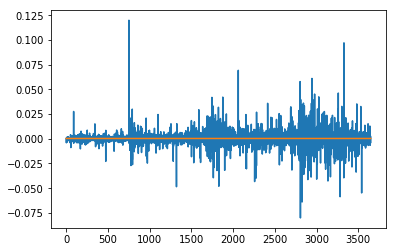

In [39]:
from matplotlib import pyplot as plt
plt.plot(Y_test[:,-1,0])
plt.plot(y_pred[:,-1,0])
plt.show()

In [97]:
X_test.shape

(3650, 24, 1)

In [99]:
3650  + 14578

18228

In [93]:
x_full.shape

(18228, 24, 1)

In [52]:
len(Y_zipped)

18228

In [59]:
X_train[:2]

array([[0.0383442 , 0.03755781, 0.03542172, 0.03576532, 0.03624779,
        0.03601254, 0.0351032 , 0.03368631, 0.03445006, 0.03241559,
        0.0329673 , 0.03333935, 0.03319674, 0.03146564, 0.032465  ,
        0.03210044, 0.03250187, 0.03254098, 0.03423297, 0.03310729,
        0.03422979, 0.03527406, 0.03496864, 0.03406117],
       [0.03755781, 0.03542172, 0.03576532, 0.03624779, 0.03601254,
        0.0351032 , 0.03368631, 0.03445006, 0.03241559, 0.0329673 ,
        0.03333935, 0.03319674, 0.03146564, 0.032465  , 0.03210044,
        0.03250187, 0.03254098, 0.03423297, 0.03310729, 0.03422979,
        0.03527406, 0.03496864, 0.03406117, 0.03477008]])

In [60]:
Y_train[:2]

array([[-0.00559965, -0.01529614,  0.00249869,  0.00349979, -0.00170052,
        -0.00658448, -0.0103276 ,  0.00562498, -0.01490002,  0.00410174,
         0.00275469, -0.00105303, -0.01279563,  0.00748262, -0.00270932,
         0.00299145,  0.00029058,  0.01256749, -0.00825737,  0.0083026 ,
         0.00766043, -0.00222345, -0.00662096,  0.00520673],
       [-0.01529614,  0.00249869,  0.00349979, -0.00170052, -0.00658448,
        -0.0103276 ,  0.00562498, -0.01490002,  0.00410174,  0.00275469,
        -0.00105303, -0.01279563,  0.00748262, -0.00270932,  0.00299145,
         0.00029058,  0.01256749, -0.00825737,  0.0083026 ,  0.00766043,
        -0.00222345, -0.00662096,  0.00520673, -0.00468888]])

In [50]:
len(all_data_transformed)

18229

In [57]:
len(X_train)

14578

In [58]:
len(X_test)

3650

In [56]:
3650 + 14578

18228

In [49]:
len(X_train)

14578

In [22]:
def get_x_y(data):
    return np.array([x[0] for x in data]), np.array([x[1] for x in data])

In [23]:
data_x, data_y = get_x_y(data_to_train)

In [24]:
data_x_test, data_y_test = get_x_y(data_to_test)

In [24]:
data_x.shape

(14578, 24)

In [25]:
data_x_lstm_train = data_x.reshape(*data_x.shape,1)
data_x_lstm_test = data_x_test.reshape(*data_x_test.shape,1)
data_y_lstm_train = data_y.reshape(*data_y.shape,1)
data_y_lstm_test = data_y_test.reshape(*data_y_test.shape,1)

## Construyendo el modelo

In [26]:
max_len = 24
batch_size = 1
print('Build STATEFUL model...')
model = Sequential()
model.add(LSTM(256, batch_input_shape=(1, 1, 1), return_sequences=False, stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

Build STATEFUL model...


In [27]:
print('Train...')
max_len = 24
for epoch in range(30):
    mean_tr_acc = []
    mean_tr_loss = []
    for i in range(len(data_x_lstm_train)):
        y_true = data_y_lstm_train[i]
        for j in range(max_len):
            tr_loss, tr_acc = model.train_on_batch(np.expand_dims(np.expand_dims(data_x_lstm_train[i][j], axis=1), axis=1),
                                                   np.array([y_true]))
            mean_tr_acc.append(tr_acc)
            mean_tr_loss.append(tr_loss)
        model.reset_states()

    print('accuracy training = {}'.format(np.mean(mean_tr_acc)))
    print('loss training = {}'.format(np.mean(mean_tr_loss)))
    print('___________________________________')

    mean_te_acc = []
    mean_te_loss = []
    for i in range(len(data_x_lstm_test)):
        for j in range(max_len):
            te_loss, te_acc = model.test_on_batch(np.expand_dims(np.expand_dims(data_x_lstm_test[i][j], axis=1), axis=1),
                                                  data_y_lstm_test[i])
            mean_te_acc.append(te_acc)
            mean_te_loss.append(te_loss)
        model.reset_states()

        for j in range(max_len):
            y_pred = model.predict_on_batch(np.expand_dims(np.expand_dims(data_x_lstm_test[i][j], axis=1), axis=1))
        model.reset_states()

    print('accuracy testing = {}'.format(np.mean(mean_te_acc)))
    print('loss testing = {}'.format(np.mean(mean_te_loss)))
    print('___________________________________')

Train...
accuracy training = 9.909360960591584e-05
loss training = 9.909360960591584e-05
___________________________________


ValueError: Error when checking target: expected dense to have 2 dimensions, but got array with shape ()

In [28]:
predictions = []
for i in range(len(data_x_lstm_test)):
        y_pred = None
        for j in range(max_len):
            y_pred = model.predict_on_batch(np.expand_dims(np.expand_dims(data_x_lstm_test[i][j], axis=1), axis=1))
        predictions.append(y_pred)
        model.reset_states()

In [31]:
data_x_lstm_test

array([[[0.11131175],
        [0.11098369],
        [0.11082891],
        ...,
        [0.11314541],
        [0.11291222],
        [0.11287405]],

       [[0.11098369],
        [0.11082891],
        [0.11099229],
        ...,
        [0.11291222],
        [0.11287405],
        [0.11288153]],

       [[0.11082891],
        [0.11099229],
        [0.11147138],
        ...,
        [0.11287405],
        [0.11288153],
        [0.11200663]],

       ...,

       [[0.43610772],
        [0.43568158],
        [0.43645449],
        ...,
        [0.45853888],
        [0.45925117],
        [0.46060946]],

       [[0.43568158],
        [0.43645449],
        [0.4431809 ],
        ...,
        [0.45925117],
        [0.46060946],
        [0.46208961]],

       [[0.43645449],
        [0.4431809 ],
        [0.44300368],
        ...,
        [0.46060946],
        [0.46208961],
        [0.46004802]]])

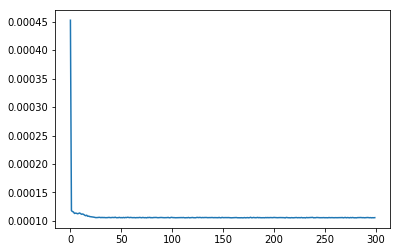

In [29]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.show()

In [30]:
data_y_pr = d_model.predict(data_x_test.reshape(data_x_test.shape[0], hours_history_length, 1))

In [31]:
data_y_pr

array([[0.00067789],
       [0.00067791],
       [0.00067846],
       ...,
       [0.00037114],
       [0.00037033],
       [0.00037055]], dtype=float32)

In [32]:
data_y_pr

array([[0.00067789],
       [0.00067791],
       [0.00067846],
       ...,
       [0.00037114],
       [0.00037033],
       [0.00037055]], dtype=float32)

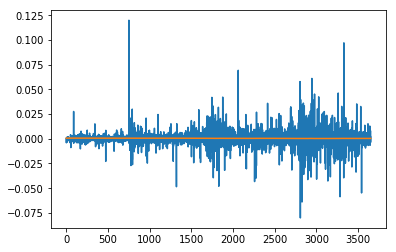

In [33]:
plt.plot(data_y_test)
plt.plot(data_y_pr)

In [127]:
x_data = np.array(data_to_train)[:,0]

In [137]:
np.array(list([(x) for x in bg] for bg in np.array(data_to_train)[:,1])).shape

SyntaxError: invalid syntax (<ipython-input-137-978927435a41>, line 1)

In [125]:
np.array(x_data)[0].ca

dtype('float64')

In [49]:
data_to_train[:,0][0].shape

(24,)

# Anexo

In [92]:
plotly.offline.plot({
"data": [
        plotly.graph_objs.Line( name="High", x=result_pandas["datetime"], y=result_pandas["high_btc"]),
        plotly.graph_objs.Line( name="Close", x=result_pandas["datetime"], y=result_pandas["close_btc"])
,
    
    plotly.graph_objs.Line(name = "Low", x=result_pandas["datetime"], y=result_pandas["low_btc"])
],
'layout': {'title': 'Volumen de tweets en periodo 2016-01 a 2019-08'}
}, filename=graficas_path+"/bitcoin_dataframe.html")

/home/juan/Documentos/personal/tesis/bitcoin_trader/bt_kernel/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




'graficas//bitcoin_dataframe.html'

## Mezclando ambas partes

In [19]:
start_date = dt.date(2017,7,1)
end_date= dt.date(2019,8,1)
crypto_dataframe = result_pandas[(result_pandas["datetime"]>=start_date) & (result_pandas["datetime"] <=end_date)]
tw_dataframe = day_count_dataframe[(day_count_dataframe["date"]>=start_date) & (day_count_dataframe["date"] <=end_date)]
plotly.offline.plot({
"data": [
        plotly.graph_objs.Line( name="High", x=crypto_dataframe["datetime"], y=crypto_dataframe["high_btc"]),
        plotly.graph_objs.Line( name="Close", x=crypto_dataframe["datetime"], y=crypto_dataframe["close_btc"]),   
        plotly.graph_objs.Line(name = "Low", x=crypto_dataframe["datetime"], y=crypto_dataframe["low_btc"]),
    
        plotly.graph_objs.Bar( x=tw_dataframe["date"], y=tw_dataframe["count"])

],
'layout': {'title': 'Volumen de tweets en periodo 2017-07 a 2019-08'}
}, filename=graficas_path+"/bitcoin_twitter.html")


/home/juan/Documentos/tesis/bitcoin_trader/bt_kernel/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning:

Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.

/home/juan/Documentos/tesis/bitcoin_trader/bt_kernel/lib/python3.5/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




'graficas//bitcoin_twitter.html'

In [20]:
crypto_dataframe.count()

date              18252
hour              18252
close_btc         18252
high_btc          18252
low_btc           18252
volume_btc        18252
volume_btc_usd    18252
close_eth         18252
high_eth          18252
low_eth           18252
volume_eth        18252
volume_eth_usd    18252
datetime          18252
dtype: int64